# Task 2. Date classification.

### Prerequisites

[ARTM_TUTORIAL](https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_EN.ipynb)

### Imports

In [ ]:
# necessary utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path


# for progress bar
from tqdm.notebook import tqdm

# ml
import sklearn
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.tensorboard import SummaryWriter

# ARTM
import artm

### Get available device

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading dataset
Note that dataset was conveniently preprocessed before.

In [12]:
dataset = pd.read_csv('./topicmodeling/lenta-ru-proccess.csv')

Нам надо сделать датасет с текстом и датой (годом), добавить модальности и сделать классификацию.
Для этого я преобразую датасет

Let's add folders for modified datasets.

In [13]:
!mkdir taskmodeling
!mkdir ./taskmodeling/vw_data

mkdir: cannot create directory ‘taskmodeling’: File exists
mkdir: cannot create directory ‘./taskmodeling/vw_data’: File exists


Now, let's add `year`, `month` and `topic` fields to dataset.

In [14]:
regex = re.compile(r'\W+')

DATASET_PATH = './taskmodeling/vw_data'
STARTING_YEAR, FINISHING_YEAR = 1999, 2021

def addMonthAndYear():
    dstest  = open(f'{DATASET_PATH}/test_ds.txt',  'w')
    dstrain = open(f'{DATASET_PATH}/train_ds.txt', 'w')
    tr_i, t_i  = 0, 0
    test_ans, train_ans = list(), list()
    year_cnt = {year: 0 for year in range(STARTING_YEAR, FINISHING_YEAR)}
    t_cnt = {year: 0 for year in range(STARTING_YEAR, FINISHING_YEAR)}

    for instance in tqdm(range(len(dataset))):
        unproc = (regex.sub(' ', dataset.loc[instance]['text']).strip()).split()
        # get date
        cur_date = dataset.loc[instance]['date']
        cur_month, cur_year = cur_date.split('-')[1], cur_date.split('-')[2]
        
        # get topic
        cur_topic =   str(dataset.loc[instance]['tags']).lower().strip()
        text = ' '.join(unproc)

        try:
            if year_cnt[int(cur_year)] < 1000:
                # write
                dstrain.write(f'doc_{tr_i} {text} ')
                dstrain.write(f'|@topic class_{cur_month} ')
                dstrain.write(f'|@month class_{cur_topic} ')
                dstrain.write(f'|@year class_{cur_year} ')
                dstrain.write(f'\n')

                tr_i += 1
                train_ans.append(cur_year)
                
                year_cnt[int(cur_year)] += 1
            else:
                if t_cnt[int(cur_year)] < 1000:
                    # write 
                    dstest.write(f'doc_{tr_i} {text} ')
                    dstest.write(f'|@topic class_{cur_month} ')
                    dstest.write(f'|@month class_{cur_topic} ')
                    dstest.write(f'\n')
                
                    t_i += 1
                    test_ans.append(cur_year)
                
                    t_cnt[int(cur_year)] += 1
        except:
            pass
        
    test_ans_file  = open(f'{DATASET_PATH}/test_ans.txt',  'w')
    train_ans_file = open(f'{DATASET_PATH}/train_ans.txt', 'w')
    test_ans_file.write('\n'.join(test_ans))
    train_ans_file.write('\n'.join(test_ans))

# modifying dataset
addMonthAndYear()

# opening results
tst_ans  = open(f'{DATASET_PATH}/test_ans.txt').read().split('\n')
tr_ans = open(f'{DATASET_PATH}/train_ans.txt').read().split('\n')

  0%|          | 0/863285 [00:00<?, ?it/s]

Create batches folder

In [15]:
BATCH_PT = './taskmodeling/batches'

!mkdir ./taskmodeling/batches
!ls ./taskmodeling/batches/

mkdir: cannot create directory ‘./taskmodeling/batches’: File exists
test_batches  train_batches


In [16]:
def createBatchVectors():
    batch_tr_path = Path(f'{BATCH_PT}/train_batches').resolve()    
    if batch_tr_path.exists():
        tr_bv = artm.BatchVectorizer(data_path=f'{BATCH_PT}/train_batches', data_format='batches')
        tst_bv  = artm.BatchVectorizer(data_path=f'{BATCH_PT}/test_batches',  data_format='batches')
    else:
        tr_bv = artm.BatchVectorizer(
            data_path=f'{DATASET_PATH}/train_ds.txt',
            data_format='vowpal_wabbit',
            batch_size=1000, 
            target_folder=f'{BATCH_PT}/train_batches'
        )
        
        tst_bv = artm.BatchVectorizer(
            data_path=f'{DATASET_PATH}/test_ds.txt',
            data_format='vowpal_wabbit',
            batch_size=1000,
            target_folder=f'{BATCH_PT}/test_batches'
        )

    # return batch vectors
    return tr_bv, tst_bv

tr_bv, tst_bv = createBatchVectors()
# check if everything was created
!ls ./taskmodeling/batches/ 

test_batches  train_batches


### Getting dictionary

Now let's get `artm` dictionary for our model.

In [17]:
artm_dict = artm.Dictionary()
artm_dict.gather(data_path=f'{BATCH_PT}/train_batches')

## Making model

Let's set model path

In [18]:
!mkdir ./taskmodeling/model
!ls ./taskmodeling/model

ARTM_MODEL_PATH = './taskmodeling/model'

## Create default 'artm' model

In [19]:
default_writer = SummaryWriter(log_dir = f'./taskmodeling/model/log/default')

artm_model = artm.ARTM(num_topics=96, dictionary=artm_dict, class_ids={'@default_class': 1.0,}, cache_theta=False)
artm_model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=artm_dict))

In [20]:
for instance in range(25):
    artm_model.fit_offline(tr_bv, num_collection_passes=1)
    val = artm_model.score_tracker['PerplexityScore'].value[-1]
    default_writer.add_scalar('PerplexityScore/train', val, 0)

# save model
artm_model.dump_artm_model(f'{ARTM_MODEL_PATH}/default')


# transform and generate dataset
prob_mtx_train = artm_model.transform(tr_bv)
def generate_dataset(m, train_bv, test_bv):
    m_transformed = m.transform(train_bv)
    X_tr = []

    for i in tqdm(range(len(tr_ans))):
        X_tr.append(m_transformed[i].values)
    X_tr = np.array(X_tr)
    y_tr = np.array(tr_ans)
    X_tr, y_tr = shuffle(X_tr, y_tr,random_state=42)

    mtx_tst = m.transform(test_bv)
    X_tst = []
    
    for i in tqdm(range(len(tst_ans))):
        X_tst.append(mtx_tst[i].values)
    
    return X_tr, y_tr, X_tst


X_def_tr, y_def_tr, X_def_test = generate_dataset(artm_model, tr_bv, tst_bv)

# creating classifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_def_tr, y_def_tr)
out = classifier.predict(X_def_test)

# reporting
print(sklearn.metrics.classification_report(tst_ans, out, zero_division=1))

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        1999       0.11      0.25      0.15      1000
        2000       0.12      0.21      0.15      1000
        2001       0.09      0.12      0.11      1000
        2002       0.08      0.10      0.09      1000
        2003       0.10      0.11      0.10      1000
        2004       0.08      0.09      0.08      1000
        2005       0.12      0.12      0.12      1000
        2006       0.07      0.06      0.07      1000
        2007       0.06      0.05      0.05      1000
        2008       0.07      0.06      0.06      1000
        2009       0.12      0.09      0.10      1000
        2010       0.06      0.05      0.06      1000
        2011       0.09      0.07      0.08      1000
        2012       0.09      0.06      0.07      1000
        2013       0.08      0.07      0.08      1000
        2014       0.07      0.06      0.07      1000
        2015       0.15      0.12      0.13      1000
        2016       0.10    

## Adding regulators

### Let's add topics

In [21]:
# creating artm model
model_for_topic = artm.ARTM(num_topics=96, dictionary=artm_dict,
                  class_ids={'@default_class': 1.0, '@topic': 3.0}, cache_theta=False)

# writing the log
wr_topic = SummaryWriter(log_dir = f'{ARTM_MODEL_PATH}/log/topic_model')


# add scored with IDs of classes
# adding scores
model_for_topic.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=artm_dict))
model_for_topic.scores.add(artm.SparsityPhiScore(name='SparcityPhiTopic', class_id='@topic'))
model_for_topic.scores.add(artm.SparsityPhiScore(name='SparcityPhiMonth', class_id='@month'))

# fitting values from model
for instance in range(15):
    model_for_topic.fit_offline(tr_bv, num_collection_passes=1)
    score = model_for_topic.score_tracker['PerplexityScore'].value[-1]
    wr_topic.add_scalar('PerplexityScore/train', score, 0)
    tag_val = model_for_topic.score_tracker['SparcityPhiTopic'].value[-1]
    wr_topic.add_scalar('SparcityPhiTopic/train', tag_val, 0)

# saving model
model_for_topic.dump_artm_model(f'{ARTM_MODEL_PATH}/topic_model/')

### Drawing graph 

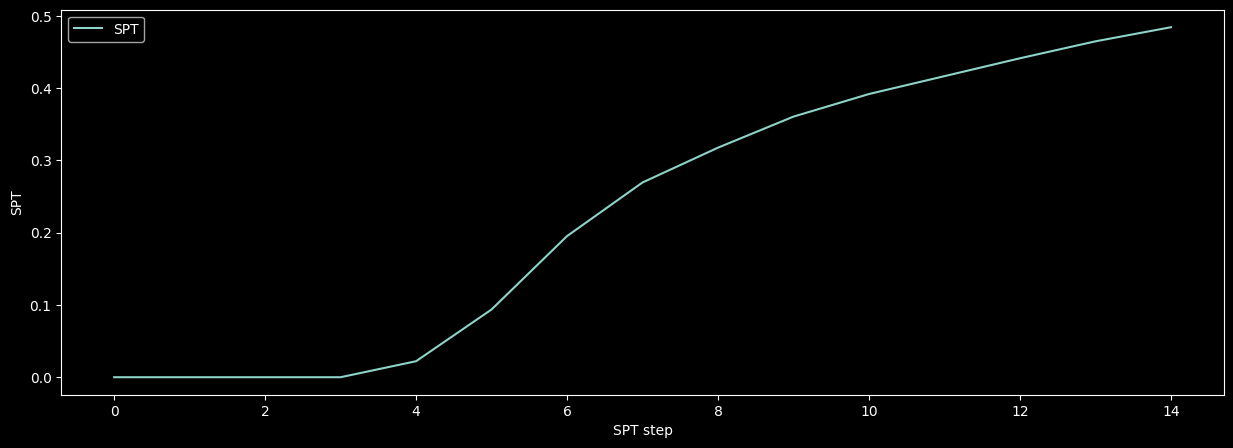

In [22]:
plt.style.use('dark_background')
plt.figure(figsize=(15,5))

plt.plot(model_for_topic.score_tracker['SparcityPhiTopic'].value, label = 'SPT')
plt.xlabel('SPT step')
plt.ylabel('SPT')
plt.legend()
plt.show()

In [23]:
# transforming train
transformed_model_for_topic = model_for_topic.transform(tr_bv)
train_x_topic = [transformed_model_for_topic[instance].values for instance in range(len(tr_ans))]

# getting numpy arrays
x_ttn = np.array(train_x_topic)
y_ttn = np.array(tr_ans)
# shuffling 
x_ttn, y_ttn = shuffle(x_ttn, y_ttn, random_state=42)

# transforming test
test_model_topic_transformed = model_for_topic.transform(tst_bv)
x_tt = [test_model_topic_transformed[instance].values for instance in range(len(tst_ans))]


# starting classifier with more estimators
classifier = RandomForestClassifier(n_estimators=96)
classifier.fit(x_ttn, y_ttn)
out = classifier.predict(x_tt)
print(sklearn.metrics.classification_report(tst_ans, out, zero_division=1))

              precision    recall  f1-score   support

        1999       0.20      0.58      0.29      1000
        2000       0.23      0.55      0.32      1000
        2001       0.11      0.10      0.11      1000
        2002       0.12      0.08      0.10      1000
        2003       0.17      0.15      0.16      1000
        2004       0.11      0.13      0.12      1000
        2005       0.16      0.14      0.15      1000
        2006       0.13      0.08      0.10      1000
        2007       0.11      0.06      0.08      1000
        2008       0.14      0.09      0.11      1000
        2009       0.22      0.11      0.14      1000
        2010       0.09      0.07      0.08      1000
        2011       0.13      0.08      0.10      1000
        2012       0.11      0.07      0.09      1000
        2013       0.12      0.10      0.11      1000
        2014       0.14      0.12      0.13      1000
        2015       0.22      0.20      0.21      1000
        2016       0.15    

### Let's consider month as well

In [24]:
mm = artm.ARTM(num_topics=96, dictionary=artm_dict,
                  class_ids={'@default_class': 1.0, '@month': 5.0}, cache_theta=False)
m_wr = SummaryWriter(log_dir = f'{ARTM_MODEL_PATH}/log/month_model')

# add scores
mm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=artm_dict))
mm.scores.add(artm.SparsityPhiScore(name='SparcityPhiMonth', class_id='@month'))

for instance in range(15):
    mm.fit_offline(tr_bv, num_collection_passes=1)
    score = mm.score_tracker['PerplexityScore'].value[-1]
    m_wr.add_scalar('PerplexityScore/train', score, 0)
    month_val = mm.score_tracker['SparcityPhiMonth'].value[-1]
    m_wr.add_scalar('SparcityPhiMonth/train', month_val, 0)

# save model
mm.dump_artm_model(f'{ARTM_MODEL_PATH}/month_model/')

In [25]:
X_month_train, y_month_train, X_month_test = generate_dataset(mm, tr_bv, tst_bv)
classifier = RandomForestClassifier(n_estimators=96)
classifier.fit(X_month_train, y_month_train)
out = classifier.predict(X_month_test)
print(sklearn.metrics.classification_report(tst_ans, out, zero_division=1))

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        1999       0.15      0.36      0.22      1000
        2000       0.20      0.33      0.25      1000
        2001       0.15      0.16      0.16      1000
        2002       0.17      0.14      0.15      1000
        2003       0.17      0.15      0.16      1000
        2004       0.13      0.16      0.15      1000
        2005       0.22      0.16      0.18      1000
        2006       0.13      0.08      0.10      1000
        2007       0.11      0.06      0.07      1000
        2008       0.13      0.10      0.12      1000
        2009       0.20      0.11      0.14      1000
        2010       0.11      0.13      0.12      1000
        2011       0.14      0.13      0.14      1000
        2012       0.12      0.11      0.11      1000
        2013       0.10      0.14      0.12      1000
        2014       0.19      0.17      0.18      1000
        2015       0.27      0.22      0.24      1000
        2016       0.20    

### Add both

In [26]:
m_tda = artm.Dictionary()
m_tda.gather(data_path=f'{BATCH_PT}/train_batches')
mtm = artm.ARTM(num_topics=96, dictionary=m_tda,
                  class_ids={'@default_class': 1.0, '@month': 15.0, '@topic': 15.0}, cache_theta=False)
mt_wr = SummaryWriter(log_dir = f'{ARTM_MODEL_PATH}/log/month_topic_model')

# add scores
mtm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=m_tda))
mtm.scores.add(artm.SparsityPhiScore(name='SparcityPhiMonth', class_id='@month'))

for instance in range(15):
    mtm.fit_offline(tr_bv, num_collection_passes=1)
    score = mtm.score_tracker['PerplexityScore'].value[-1]
    mt_wr.add_scalar('PerplexityScore/train', score, 0)
    tag_val = model_for_topic.score_tracker['SparcityPhiTopic'].value[-1]
    wr_topic.add_scalar('SparcityPhiTopic/train', tag_val, 0)
    month_val = mtm.score_tracker['SparcityPhiMonth'].value[-1]
    mt_wr.add_scalar('SparcityPhiMonth/train', month_val, 0)

# save model
mtm.dump_artm_model(f'{ARTM_MODEL_PATH}/month_topic_model/')

In [27]:
X_month_topic_train, y_month_topic_train, X_month_topic_test = generate_dataset(mtm, tr_bv, tst_bv)

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

In [28]:
X_month_topic_train, y_month_topic_train, X_month_topic_test = generate_dataset(mtm, tr_bv, tst_bv)

classifier = RandomForestClassifier(n_estimators=96)
classifier.fit(X_month_topic_train, y_month_topic_train)
out = classifier.predict(X_month_topic_test)
print(sklearn.metrics.classification_report(tst_ans, out, zero_division=1))

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        1999       0.59      0.56      0.57      1000
        2000       0.27      0.76      0.40      1000
        2001       0.13      0.22      0.16      1000
        2002       0.15      0.15      0.15      1000
        2003       0.13      0.12      0.13      1000
        2004       0.11      0.12      0.11      1000
        2005       0.23      0.13      0.16      1000
        2006       0.17      0.09      0.11      1000
        2007       0.11      0.06      0.08      1000
        2008       0.17      0.13      0.15      1000
        2009       0.24      0.13      0.16      1000
        2010       0.12      0.11      0.11      1000
        2011       0.14      0.12      0.13      1000
        2012       0.17      0.12      0.14      1000
        2013       0.09      0.12      0.10      1000
        2014       0.23      0.28      0.25      1000
        2015       0.27      0.20      0.23      1000
        2016       0.19    

### Finally, adding regulators

In [29]:
m_trm = artm.ARTM(num_topics=96, dictionary=m_tda,
                  class_ids={'@default_class': 1.0, '@month': 15.0, '@topic': 15.0}, cache_theta=False)
m_tr_wr = SummaryWriter(log_dir = f'{ARTM_MODEL_PATH}/log/month_topic_reg_model')

# add scores
m_trm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=m_tda))
m_trm.scores.add(artm.SparsityPhiScore(name='SparcityPhiMonth', class_id='@month'))
m_trm.scores.add(artm.SparsityPhiScore(name='SparcityTopic', class_id='@topic'))
m_trm.scores.add(artm.SparsityPhiScore(name='SparcityMonth', class_id='@month'))

m_trm.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='smooth_sparse_phi_regularizer',
    tau=-0.15,
    class_ids=['@default_class', '@month', '@topic'])
)

for instance in range(15):
    m_trm.fit_offline(tr_bv, num_collection_passes=1)
    score = m_trm.score_tracker['PerplexityScore'].value[-1]
    m_tr_wr.add_scalar('PerplexityScore/train', score, 0)
    tag_val = model_for_topic.score_tracker['SparcityPhiTopic'].value[-1]
    wr_topic.add_scalar('SparcityPhiTopic/train', tag_val, 0)
    month_val = m_trm.score_tracker['SparcityPhiMonth'].value[-1]
    m_tr_wr.add_scalar('SparcityPhiMonth/train', month_val, 0)
    sp_topic = m_trm.score_tracker['SparcityTopic'].value[-1]
    m_tr_wr.add_scalar('SparcityTopic/train', sp_topic, 0)

    sp_month = m_trm.score_tracker['SparcityMonth'].value[-1]
    m_tr_wr.add_scalar('SparcityTopic/train', sp_month, 0)
    

m_trm.dump_artm_model(f'{ARTM_MODEL_PATH}/month_topic_reg_model/')

In [30]:
X_month_topic_reg_train, y_month_topic_reg_train, X_month_topic_reg_test = generate_dataset(m_trm, tr_bv, tst_bv)

classifier = RandomForestClassifier(n_estimators=96)
classifier.fit(X_month_topic_reg_train, y_month_topic_reg_train)
out = classifier.predict(X_month_topic_reg_test)
print(sklearn.metrics.classification_report(tst_ans, out, zero_division=1))

  0%|          | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/22000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        1999       0.59      0.52      0.55      1000
        2000       0.28      0.72      0.41      1000
        2001       0.15      0.20      0.17      1000
        2002       0.16      0.19      0.17      1000
        2003       0.15      0.16      0.16      1000
        2004       0.14      0.15      0.14      1000
        2005       0.24      0.17      0.20      1000
        2006       0.19      0.12      0.15      1000
        2007       0.13      0.07      0.09      1000
        2008       0.16      0.13      0.14      1000
        2009       0.23      0.13      0.17      1000
        2010       0.15      0.12      0.13      1000
        2011       0.18      0.16      0.17      1000
        2012       0.15      0.13      0.14      1000
        2013       0.11      0.11      0.11      1000
        2014       0.23      0.28      0.25      1000
        2015       0.24      0.22      0.23      1000
        2016       0.19    

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './taskmodeling/model/log'

# Results

Results were not as good as expected.
- I wasn't able to get a high accuracy. The key problem here is the fact that it's not possible to determine the year of an article.
- Should probably use predictions using keywords (for example, "earthquakes" etc.).
- Model if very memory-inefficient, took more than 30gb...
- Should definetely cache theta matrix when working with a model,
- Adding tag, month and regulators still helped to increase the accuracy.